# $ \ell^+ \ell^- \to W^+ W^-, ZZ, ZH, \gamma \gamma, Z \gamma $ cross sections

TO-DO: Check the energy dependence \
Keep eyes open to other processes that are sensitive to the operators in game

We will try to automatize this procedure inside this Jupyter notebook.

We set the linearPropCorrections to 1 in the restriction card already. More information can be found here: https://arxiv.org/abs/2012.11343.

We use the mW input scheme, since we keep the mW fixed to its SM value. Also the widths! We do not want to go and do a global fit analysis.

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def process_to_dirname(process):
    return process.replace(" ", "").replace("+", "p").replace("-", "m").replace(">", "_")

In [3]:
def extract_cross_section(mg_path, output_dir):
    banner_path = os.path.join(mg_path, output_dir, "Events", "run_01", "run_01_tag_1_banner.txt")
    if os.path.exists(banner_path):
        with open(banner_path, "r") as f:
            for line in f:
                if line.startswith("#  Integrated weight (pb)  :"):
                    return float(re.findall(r"[-+]?[0-9]*\.?[0-9]+(?:[eE][-+]?[0-9]+)?", line)[0])
    return None

In [4]:
def run_madgraph(process, generate_cmd, params, mg_path, pt_cuts, com_energy):
    """
    Runs MadGraph for a given process and parameter set. 
    process is a string that specifies the process in the MadGraph form.
    generate_cmd is the generate command given as a string, which includes the process, but also the order of it (is it SM, NP int. or NP^2). 
    It is created in the main loop, see below.
    params is a dictionary of the form {paramWC: value}, which is created in the main loop.
    mg_path is a string that specifies the path to the MadGraph directory, more precisely it points to ~/MG5_aMC_v3_4_0/bin.
    pt_cuts is also a dictionary of the form {PDG_ID: pT}, and used to create the MadGraph commands to set the minimum pTs of the outgoing particles.
    """

    # Create the string that will set the WCs to their values
    param_str = " \n".join([f"set {k} {v}" for k, v in params.items()])
    
    # Create the string that will set the pT cuts
    pt_cut_str_1 = [f"{pdg}: {pt} " for pdg, pt in pt_cuts.items()]
    pt_cut_str = "set pt_min_pdg" + " {" + ", ".join(pt_cut_str_1) + "}"
    
    output_dir = os.path.join(mg_path, process_to_dirname(process)) # For every process, change the folder name

    ebeam = com_energy/2 # in GeV
    lambdaNP = 1_000 # in GeV
    
    script_content = f"""
    import model SMEFTsim_gen_MwScheme_UFO-HW_HB_HWB 
    define mu = mu+ mu-
    generate {generate_cmd} SMHLOOP = 0 NPprop = 0
    output {process_to_dirname(process)}
    launch
    shower = OFF
    detector = OFF
    analysis = OFF
    madspin = OFF
    reweight = OFF
    0
    set LambdaSMEFT {lambdaNP}
    set lpp1 0
    set lpp2 0
    set polbeam1 0
    set polbeam2 0
    set ebeam1 {ebeam}
    set ebeam2 {ebeam}
    set pdlabel none
    set use_syst False
    set nevents 100
    {param_str}
    {pt_cut_str}
    0
    """
    # LambdaSMEFT is set to 50 TeV!
    #lpp1 and lpp2 set to zero mean NO PDF
    #polbeam1 and polbeam2 are their polarizations, from -100 (left-handed) to 100 (right-handed)
    #pdlabel is set to none since we don't want to use any PDF
    
    script_path = os.path.join(mg_path, "run_mg5_script.txt")
    with open(script_path, "w") as f:
        f.write(script_content)
    
    os.system(f"cd {mg_path} && python3 mg5_aMC {script_path}") # Command to run MadGraph
    
    # Extract cross-section (this will depend on MG5 output format)
    cross_section = extract_cross_section(mg_path, output_dir)
    return cross_section

In [5]:
# Define processes and parameters
processes = [
    "mu+ mu- > z h"
#    "mu+ mu- > a a",
#    "mu+ mu- > w+ w-",
#    "mu+ mu- > z a",
#    "mu+ mu- > z z"
]

params_list = ["cHW", "cHWB", "cHB"]
mg_path = "/home/armanubuntu/MG5_aMC_v3_6_3/bin/" #Arman's path 
#mg_path = "/home/.../MG5_aMC_v3_6_2/bin/" #Keshav's path

os.chdir(mg_path) #Go to this folder

data = []

# Example of default pT cuts (all set to zero for now, can be modified)
default_pt_cuts = {23: 0, 25: 0, 22: 0, 24: 0}  # PDG IDs for Z, H, A, W+

In [6]:
os.path.exists(mg_path)

True

# Running MG5 (can be skipped if we have the results already)

In [7]:
#com_energies = [10000, 14000, 30000] # in GeV
com_energies = [10000] # in GeV

In [8]:
# Center-of-mass energy in TeV
for com_energy in com_energies:
    #print(f"Running for COM energy: {com_energy/1000} TeV\n")

    # Compute cross-sections
    for process in processes:
        # SM only
        xs_sm = run_madgraph(process, f" {process}", {p: 0 for p in params_list}, mg_path, default_pt_cuts, com_energy)
        data.append([process, 'SM', "SM only", xs_sm, com_energy])

        os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run

        # Interference terms. See https://answers.launchpad.net/mg5amcnlo/+question/254944 and https://answers.launchpad.net/mg5amcnlo/+question/255413 for information, but this doesn't seem correct, since NP^2 > 2 doesn't give me anything, and clearly it should.
        for param in params_list:
            generate_cmd = f" {process}  NP^2 == 1  NP{param}^2 == 1"
            xs_int = run_madgraph(process, generate_cmd, {p: 0.999999 if p == param else 0 for p in params_list}, mg_path, default_pt_cuts, com_energy)
            data.append([process, param, "Interference", xs_int, com_energy])
            os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run

        # Pure NP^2 terms
        for param in params_list:
            generate_cmd = f" {process}  NP^2 == 2  NP{param}^2 == 2"
            xs_np2 = run_madgraph(process, generate_cmd, {p: 0.999999 if p == param else 0 for p in params_list}, mg_path, default_pt_cuts, com_energy)
            data.append([process, param, "NP^2", xs_np2, com_energy])
            os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run

        # Mixed NP^2 terms
        for i in range(len(params_list)):
            for j in range(i+1, len(params_list)):
                p1, p2 = params_list[i], params_list[j]
                generate_cmd = f" {process}  NP^2 == 2  {{NP{p1}^2 == 1}}  {{NP{p2}^2 == 1}}"
                xs_mixed = run_madgraph(process, generate_cmd, {p: 0.999999 if p in [p1, p2] else 0 for p in params_list}, mg_path, default_pt_cuts, com_energy)
                data.append([process, f"{p1} + {p2}", "Mixed NP^2", xs_mixed, com_energy])
                os.system("rm -r " + os.path.join(mg_path, process_to_dirname(process))) # Delete the folder after every run so we are sure we are not reading from the previous run


In [18]:
data

[['mu+ mu- > z h', 'SM', 'SM only', 0.0001230151, 10000],
 ['mu+ mu- > z h', 'cHW', 'Interference', 0.00015220998535850003, 10000],
 ['mu+ mu- > z h', 'cHWB', 'Interference', 6.820799958679999e-05, 10000],
 ['mu+ mu- > z h', 'cHB', 'Interference', 2.70919964266e-05, 10000],
 ['mu+ mu- > z h', 'cHW', 'NP^2', 0.051905, 10000],
 ['mu+ mu- > z h', 'cHWB', 'NP^2', 0.014885815994699998, 10000],
 ['mu+ mu- > z h', 'cHB', 'NP^2', 0.0213703, 10000],
 ['mu+ mu- > z h', 'cHW + cHWB', 'Mixed NP^2', None, 10000],
 ['mu+ mu- > z h', 'cHW + cHB', 'Mixed NP^2', None, 10000],
 ['mu+ mu- > z h', 'cHWB + cHB', 'Mixed NP^2', None, 10000]]

# Analysis

In [10]:
# Save results to a DataFrame
columns = ["Process", "Operator", "Contribution", "Cross-section", "COM energy"]
df = pd.DataFrame(data, columns=columns)
df["Cross-section"] = df["Cross-section"].fillna(0.0) # Swap the "None" to 0.0
print(df)
df.to_csv("/home/armanubuntu/cross_sections_massive_muon.csv", index=False) #Arman's path to save the csv
#df.to_csv("/home/.../cross_sections_massive_muon.csv", index=False) #Keshav's path to save the csv


# Load the Dataframe if you didn't make any changes in the MG5 run
#df = pd.read_csv("/home/armanubuntu/cross_sections_ymu_0.csv")
#print(df)


         Process    Operator  Contribution  Cross-section  COM energy
0  mu+ mu- > z h          SM       SM only       0.000123       10000
1  mu+ mu- > z h         cHW  Interference       0.000152       10000
2  mu+ mu- > z h        cHWB  Interference       0.000068       10000
3  mu+ mu- > z h         cHB  Interference       0.000027       10000
4  mu+ mu- > z h         cHW          NP^2       0.051905       10000
5  mu+ mu- > z h        cHWB          NP^2       0.014886       10000
6  mu+ mu- > z h         cHB          NP^2       0.021370       10000
7  mu+ mu- > z h  cHW + cHWB    Mixed NP^2       0.000000       10000
8  mu+ mu- > z h   cHW + cHB    Mixed NP^2       0.000000       10000
9  mu+ mu- > z h  cHWB + cHB    Mixed NP^2       0.000000       10000


Here is how to extract the values out of this pandas Dataframe:

In [11]:
df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Contribution"] == "SM only") & (df["COM energy"] == 10000), "Cross-section"].values[0]

0.0001230151

Define the cross-section functions for all the processes we have ($ \ell^+ \ell^- \to W^+ W^-, ZZ, ZH, \gamma \gamma, Z \gamma $) \
(define the cross-sections as the sum of the different contributions multiplied by the corresponding WCs, and as a function of the COM energy):

In [12]:
def sigmaMupMumWW(coefficients, com_energy):
    sm = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Contribution"] == "SM only") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == param) & (df["Contribution"] == "Interference") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == param) & (df["Contribution"] == "NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > w+ w-") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumZZ(coefficients, com_energy):
    sm = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Contribution"] == "SM only") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == param) & (df["Contribution"] == "Interference") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == param) & (df["Contribution"] == "NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z z") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms




def sigmaMupMumZh(coefficients, com_energy):
    sm = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Contribution"] == "SM only") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == param) & (df["Contribution"] == "Interference") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == param) & (df["Contribution"] == "NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z h") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumAA(coefficients, com_energy):
    sm = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Contribution"] == "SM only") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == param) & (df["Contribution"] == "Interference") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == param) & (df["Contribution"] == "NP^2") & (df["COM energy"] == com_energy) , "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + ((coefficients.get(param, 0) ** 2) * np2_term)
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > a a") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms


def sigmaMupMumZa(coefficients, com_energy):
    sm = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Contribution"] == "SM only") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
    terms = sm
    for param in params_list:
        int_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == param) & (df["Contribution"] == "Interference") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        np2_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == param) & (df["Contribution"] == "NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
        terms += coefficients.get(param, 0) * int_term + coefficients.get(param, 0) ** 2 * np2_term
    for i in range(len(params_list)):
        for j in range(i+1, len(params_list)):
            p1, p2 = params_list[i], params_list[j]
            mixed_term = df.loc[(df["Process"] == "mu+ mu- > z a") & (df["Operator"] == f"{p1} + {p2}") & (df["Contribution"] == "Mixed NP^2") & (df["COM energy"] == com_energy), "Cross-section"].values[0]
            terms += coefficients.get(p1, 0) * coefficients.get(p2, 0) * mixed_term
    return terms

The way the function works: \
You give the function sigmaMupMumZh the dictionary with the values of the WCs, and then it calculates for you the whole cross-section:

In [13]:
coeffsExample = {
    "cHW": 1,
    "cHWB": 0,
    "cHB": 0
}

sigma = sigmaMupMumZh(coeffsExample, 10000)
print(f"Computed cross-section: {sigma}")

#print("Controling by summing the individual terms:", 0.000062 +  0.000002 + 0.000384)


Computed cross-section: 0.052180225085358495


# Plotting

Before plotting, make sure we understand this toy example. When plotting a grid with seaborn, it treats the first variables as y parameters, and the second as x! matplotlib.plt, axes asigning works in the normal way.

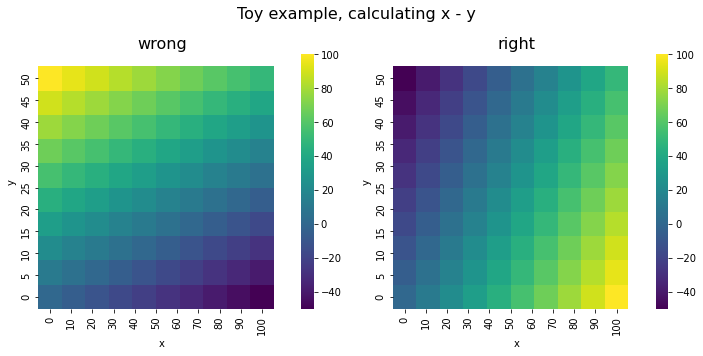

In [14]:
# Generate 2D heatmaps
fig, axes = plt.subplots(1,2, figsize=(10, 5))


x_range = np.linspace(0, 100, 10) 
y_range = np.linspace(0, 50, 10) 


x_ticks = np.linspace(x_range[0], x_range[-1], 11)
y_ticks = np.linspace(y_range[0], y_range[-1], 11)
xtick_pos = np.linspace(0.5, len(x_range) - 1 + 0.5, 11)
ytick_pos = np.linspace(0.5, len(y_range) - 1 + 0.5, 11)
grid_wrong = np.zeros((len(x_range), len(y_range)))
grid_right = np.zeros((len(x_range), len(y_range)))

for x_idx, x in enumerate(x_range):
    for y_idx, y in enumerate(y_range):
        grid_wrong[x_idx, y_idx] = x - y
        grid_right[y_idx, x_idx] = x - y # The right way to fill the grid is this one!

        
sns.heatmap(grid_wrong, ax=axes[0], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
sns.heatmap(grid_right, ax=axes[1], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)

for ax_no in range(2):
    axes[ax_no].set_xticks(xtick_pos)
    axes[ax_no].set_xticklabels([f"{label:.0f}" for label in x_ticks])
    axes[ax_no].set_yticks(ytick_pos)
    axes[ax_no].set_yticklabels([f"{label:.0f}" for label in y_ticks])
    axes[ax_no].invert_yaxis()  # Fix y-axis direction, so we go from lowest to highest values
    axes[ax_no].set_xlabel("x")
    axes[ax_no].set_ylabel("y")

axes[0].set_title("wrong", fontsize=16)
axes[1].set_title("right", fontsize=16)
        
plt.suptitle("Toy example, calculating x - y", fontsize=16)
plt.tight_layout()
plt.show()


## Results:

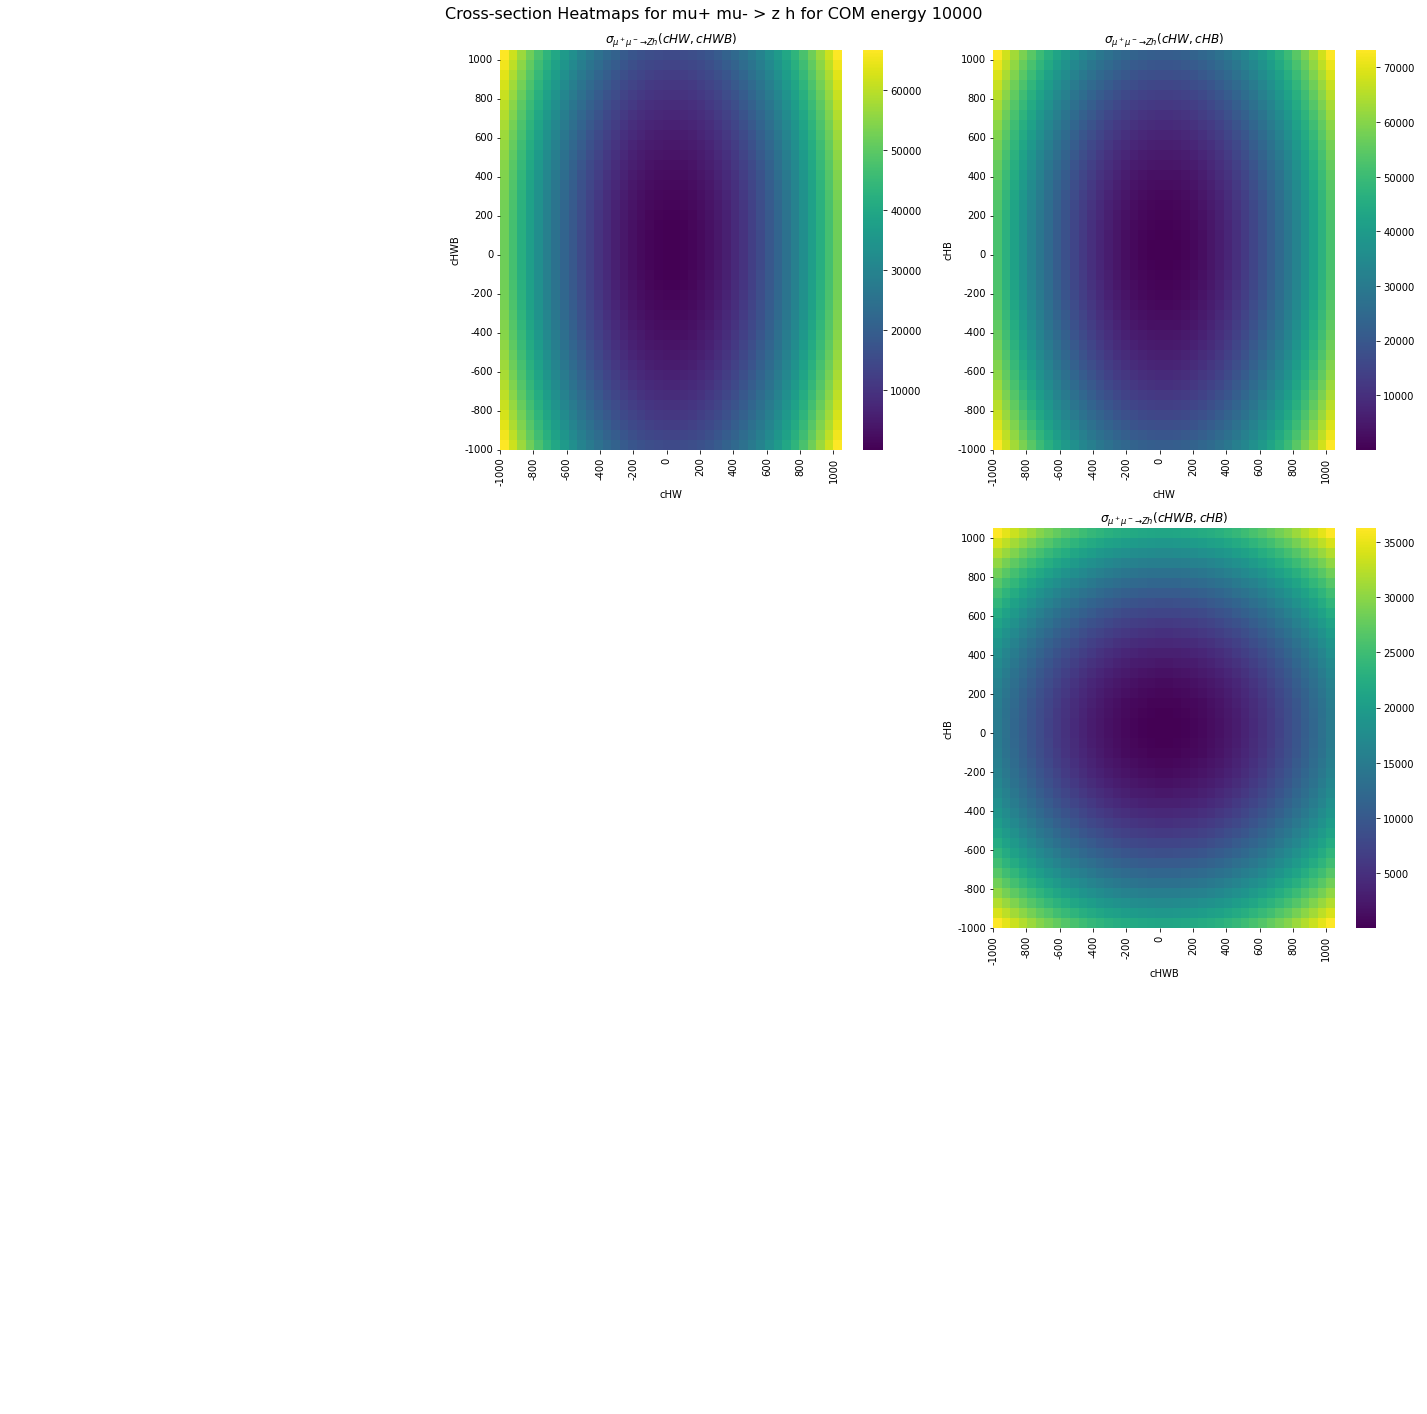

In [19]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name, com_energy):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges based on whether p1 or p2 is cHW
            x_range = np.linspace(-1000, 1000, 40) #if p1 == "cHW" else np.linspace(-100, 100, 75)
            y_range = np.linspace(-1000, 1000, 40) #if p2 == "cHW" else np.linspace(-100, 100, 75)

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZh(coeffs, com_energy)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z h}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name} for COM energy {com_energy} \n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z h", 10_000)


Explicitly checking results:

In [17]:
coeffs1 = {
    "cBB": 0,
    "cHW": 0,
    "cW": 0,
    "cHB": 0,
    "cB": 0
}

coeffs2 = {
    "cBB": 0.0,
    "cHW": 0,
    "cW": 0,
    "cHB": 0,
    "cB": 5
}

print(sigmaMupMumZh(coeffs1, 10000), sigmaMupMumZh(coeffs2, 10000))

0.0001230151 0.0001230151


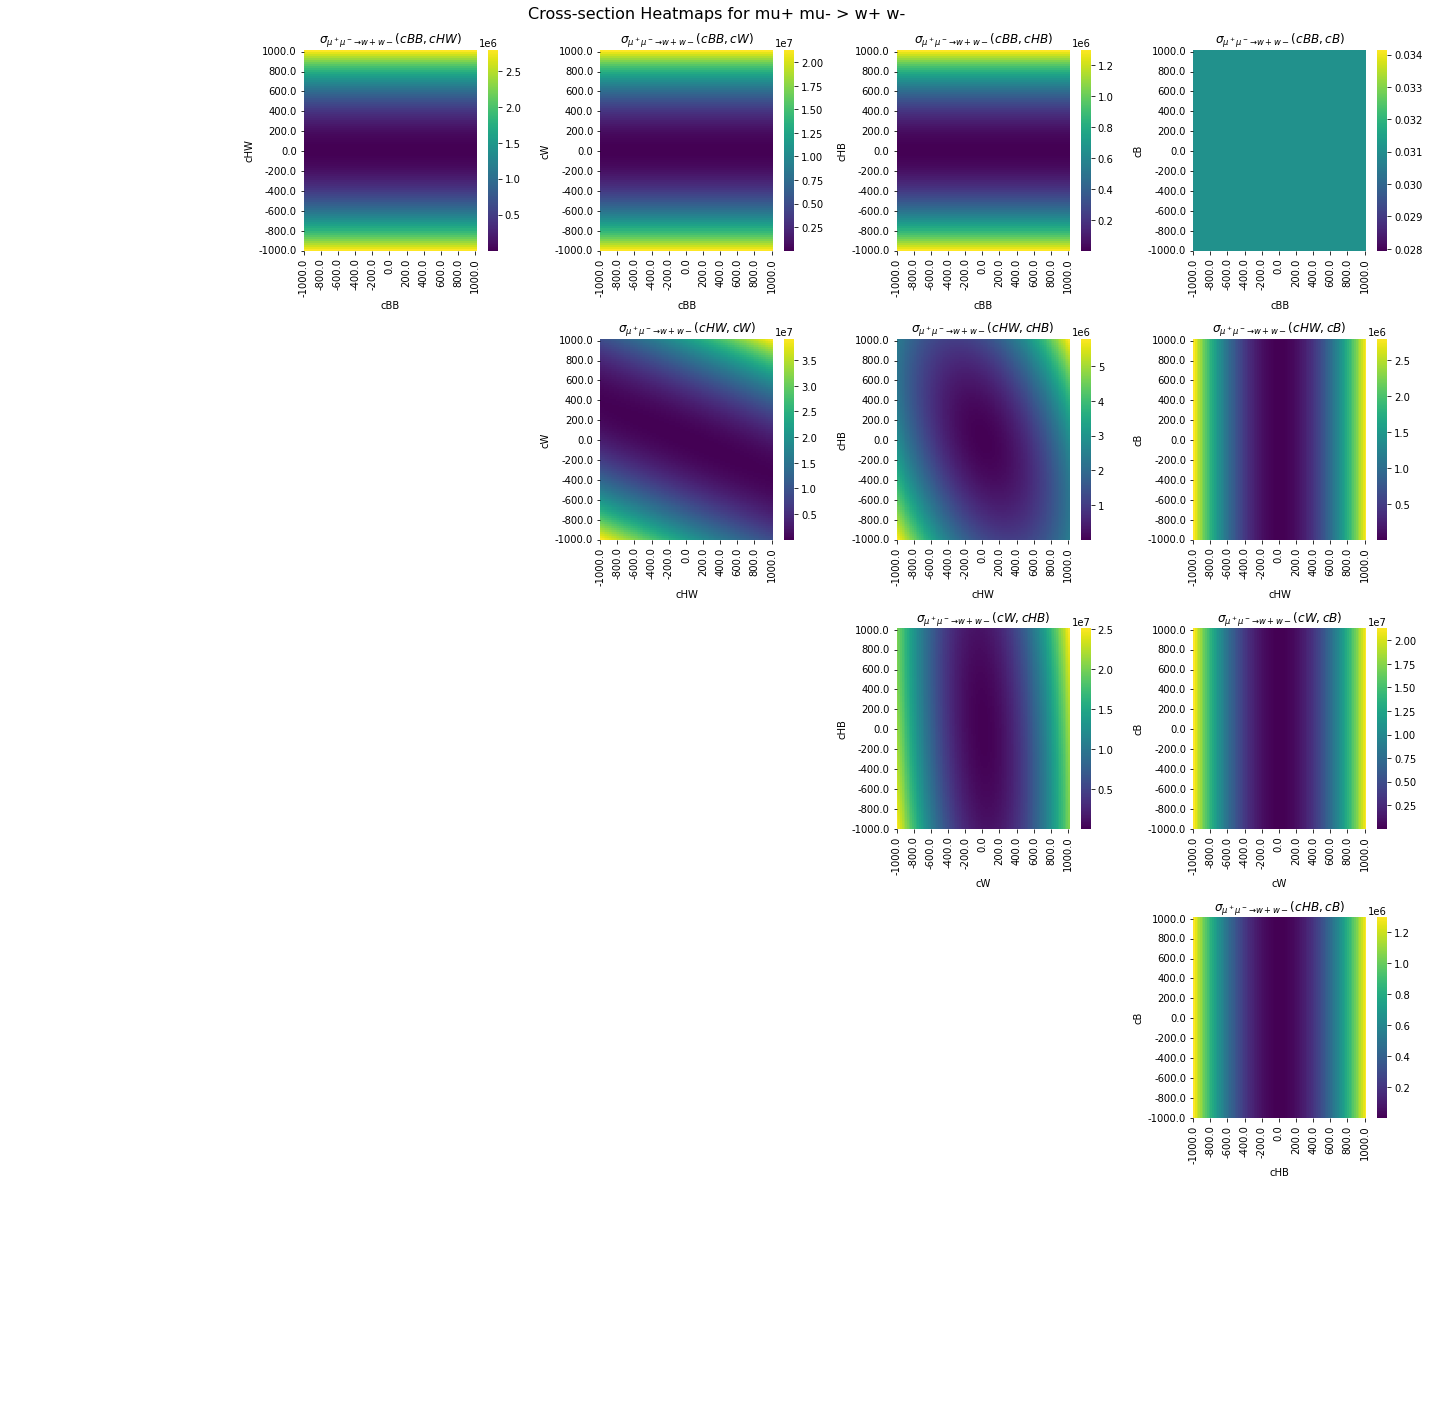

In [ ]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name, com_energy):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges based on whether p1 or p2 is cBB
            #x_range = np.linspace(-10000, 10000, 100) if p1 == "cBB" else np.linspace(-100, 100, 100)
            #y_range = np.linspace(-10000, 10000, 100) if p2 == "cBB" else np.linspace(-100, 100, 100)

            x_range = np.linspace(-1000, 1000, 100) 
            y_range = np.linspace(-1000, 1000, 100) 


            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumWW(coeffs, com_energy)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.1f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.1f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to w+ w-}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name} for COM energy {com_energy} \n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > w+ w-")


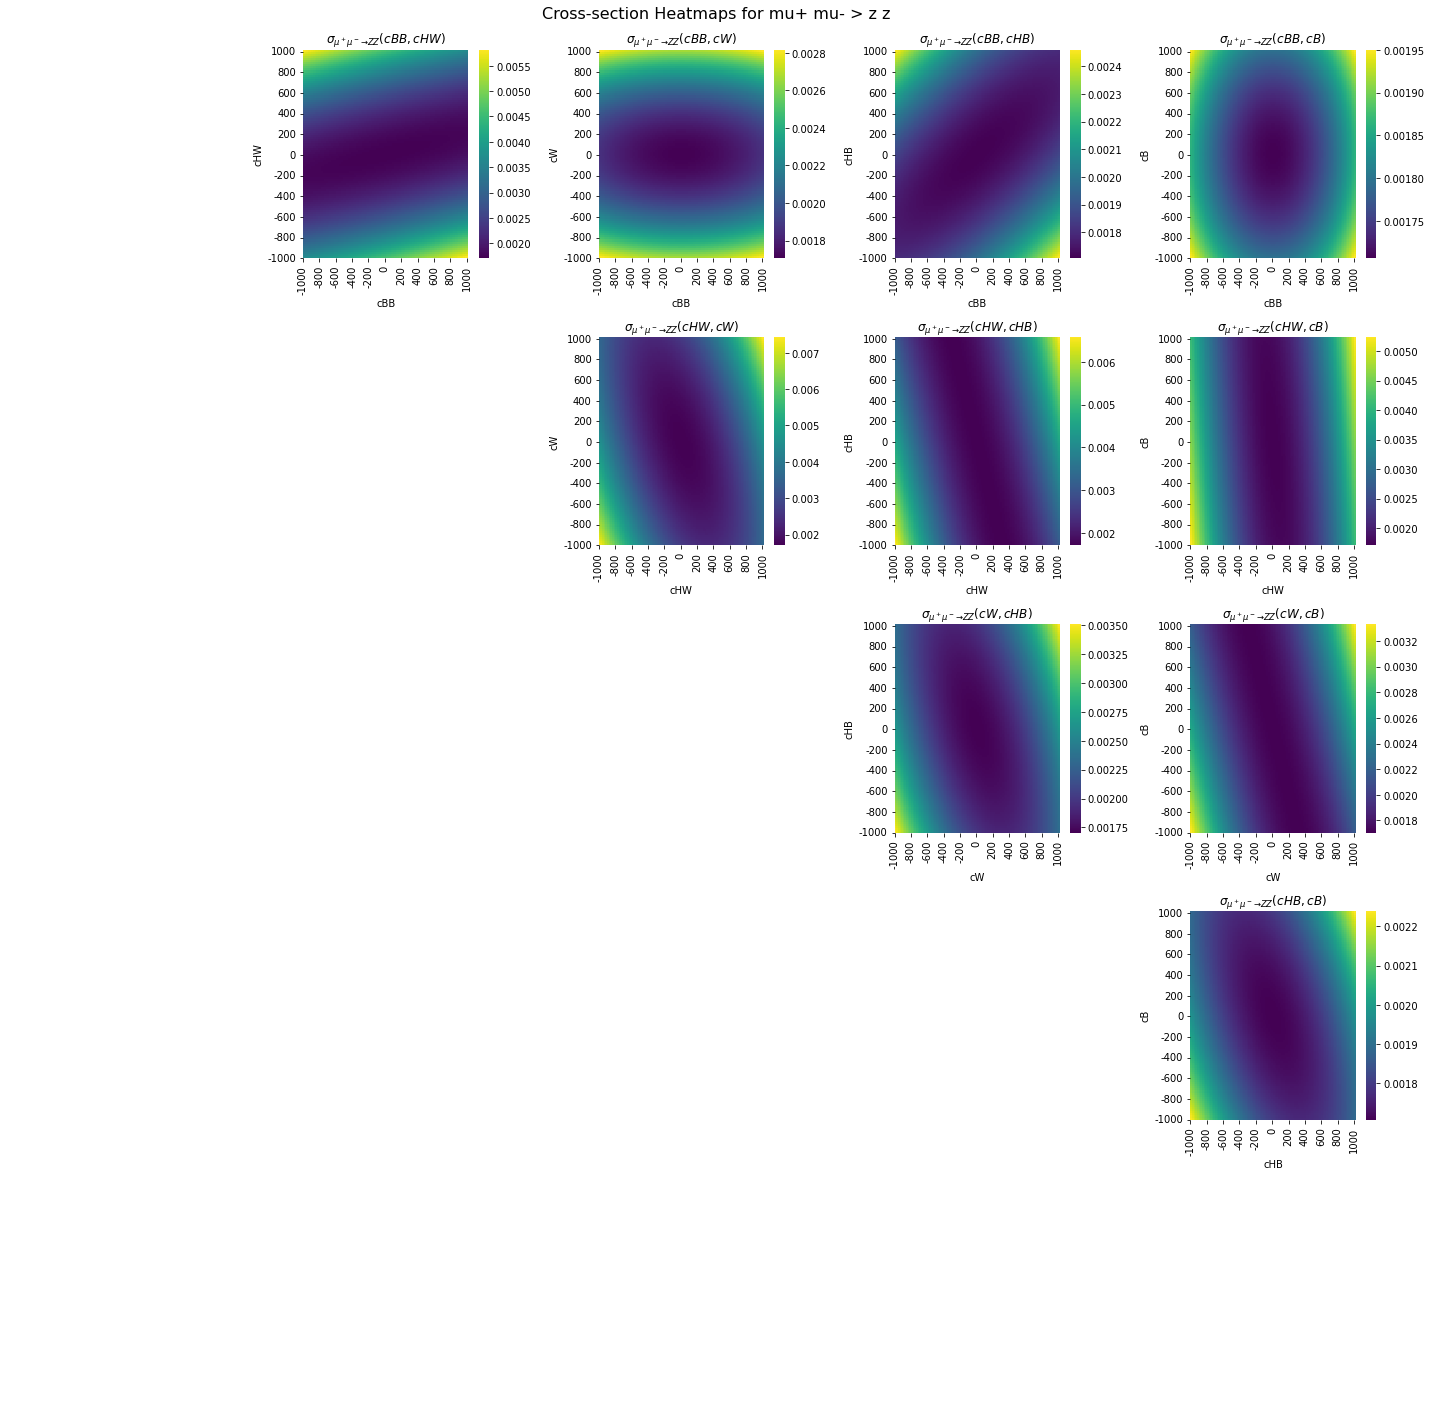

In [ ]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name, com_energy):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 100) 
            y_range = np.linspace(-1000, 1000, 100)

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZZ(coeffs, com_energy)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z Z}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name} for COM energy {com_energy}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z z")


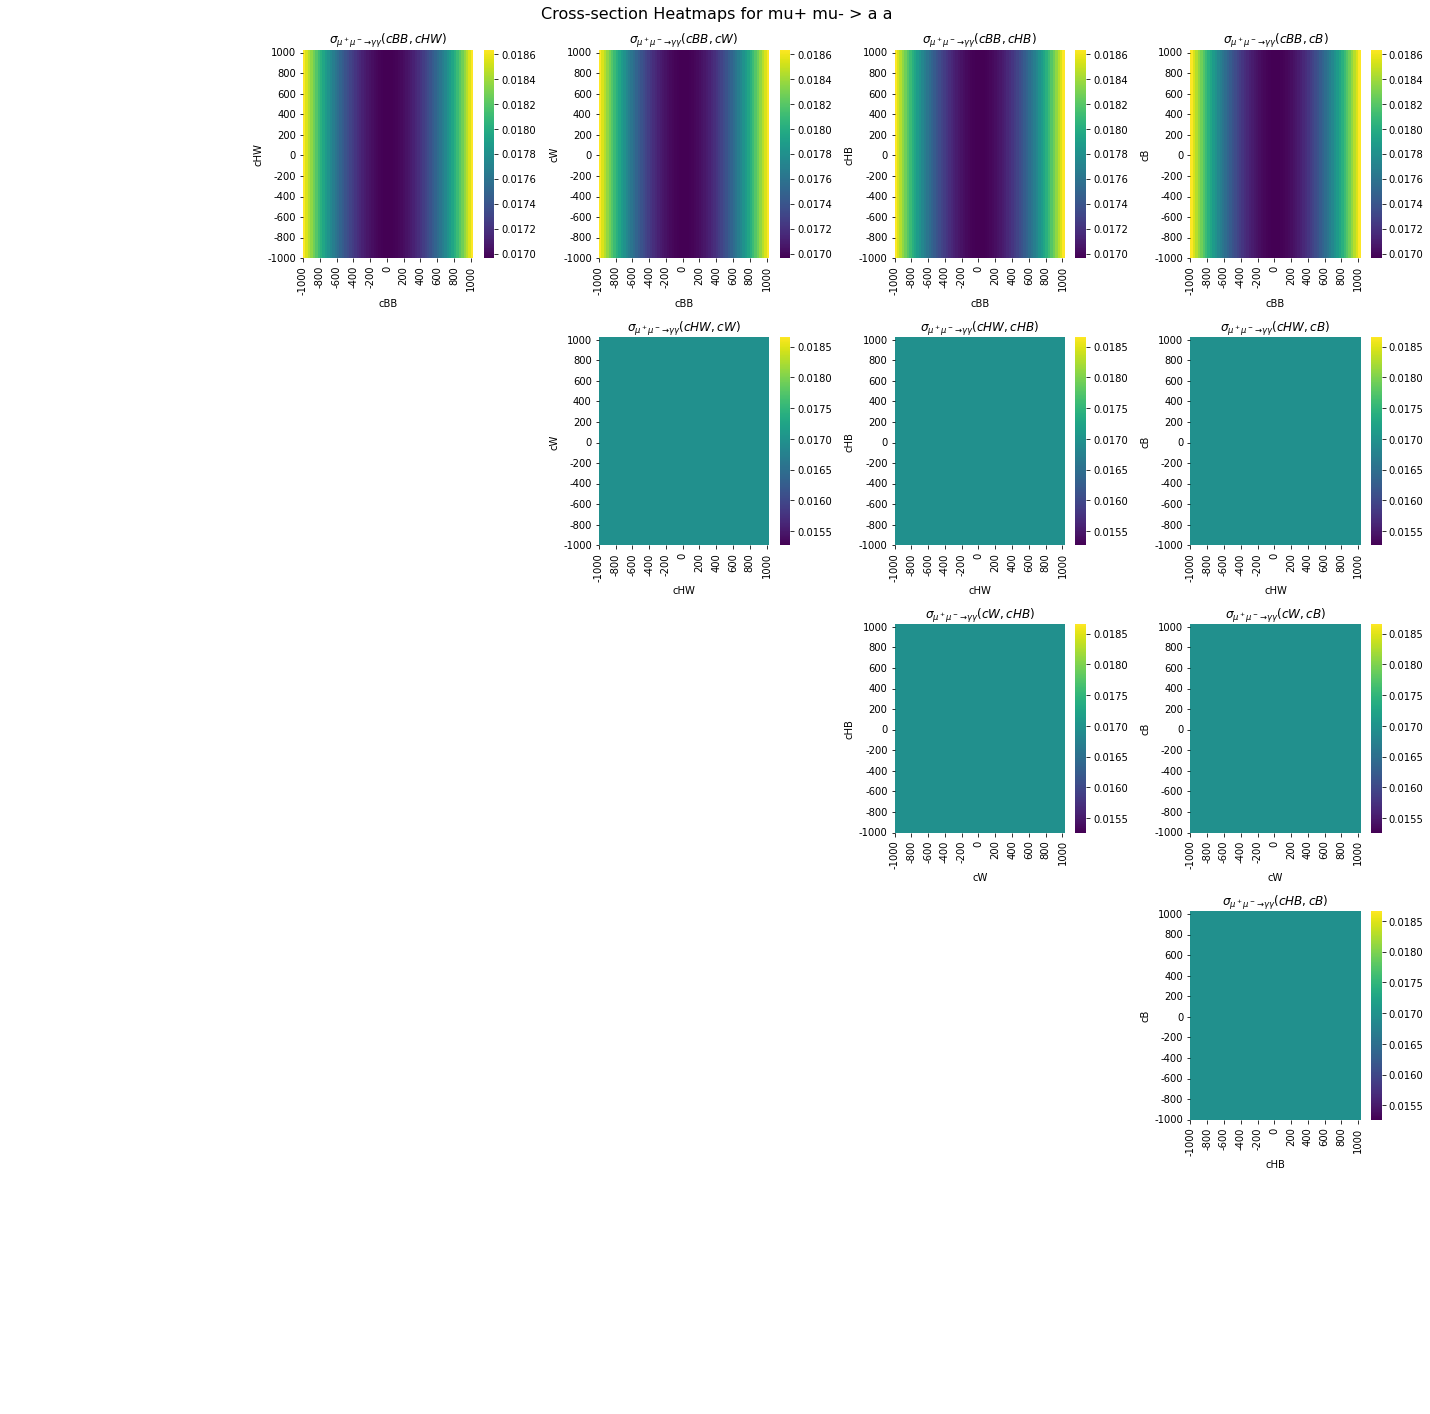

In [ ]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name, com_energy):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 70) 
            y_range = np.linspace(-1000, 1000, 70) 

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumAA(coeffs, com_energy)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to \\gamma \\gamma}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name} for COM energy {com_energy/1000}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > a a")


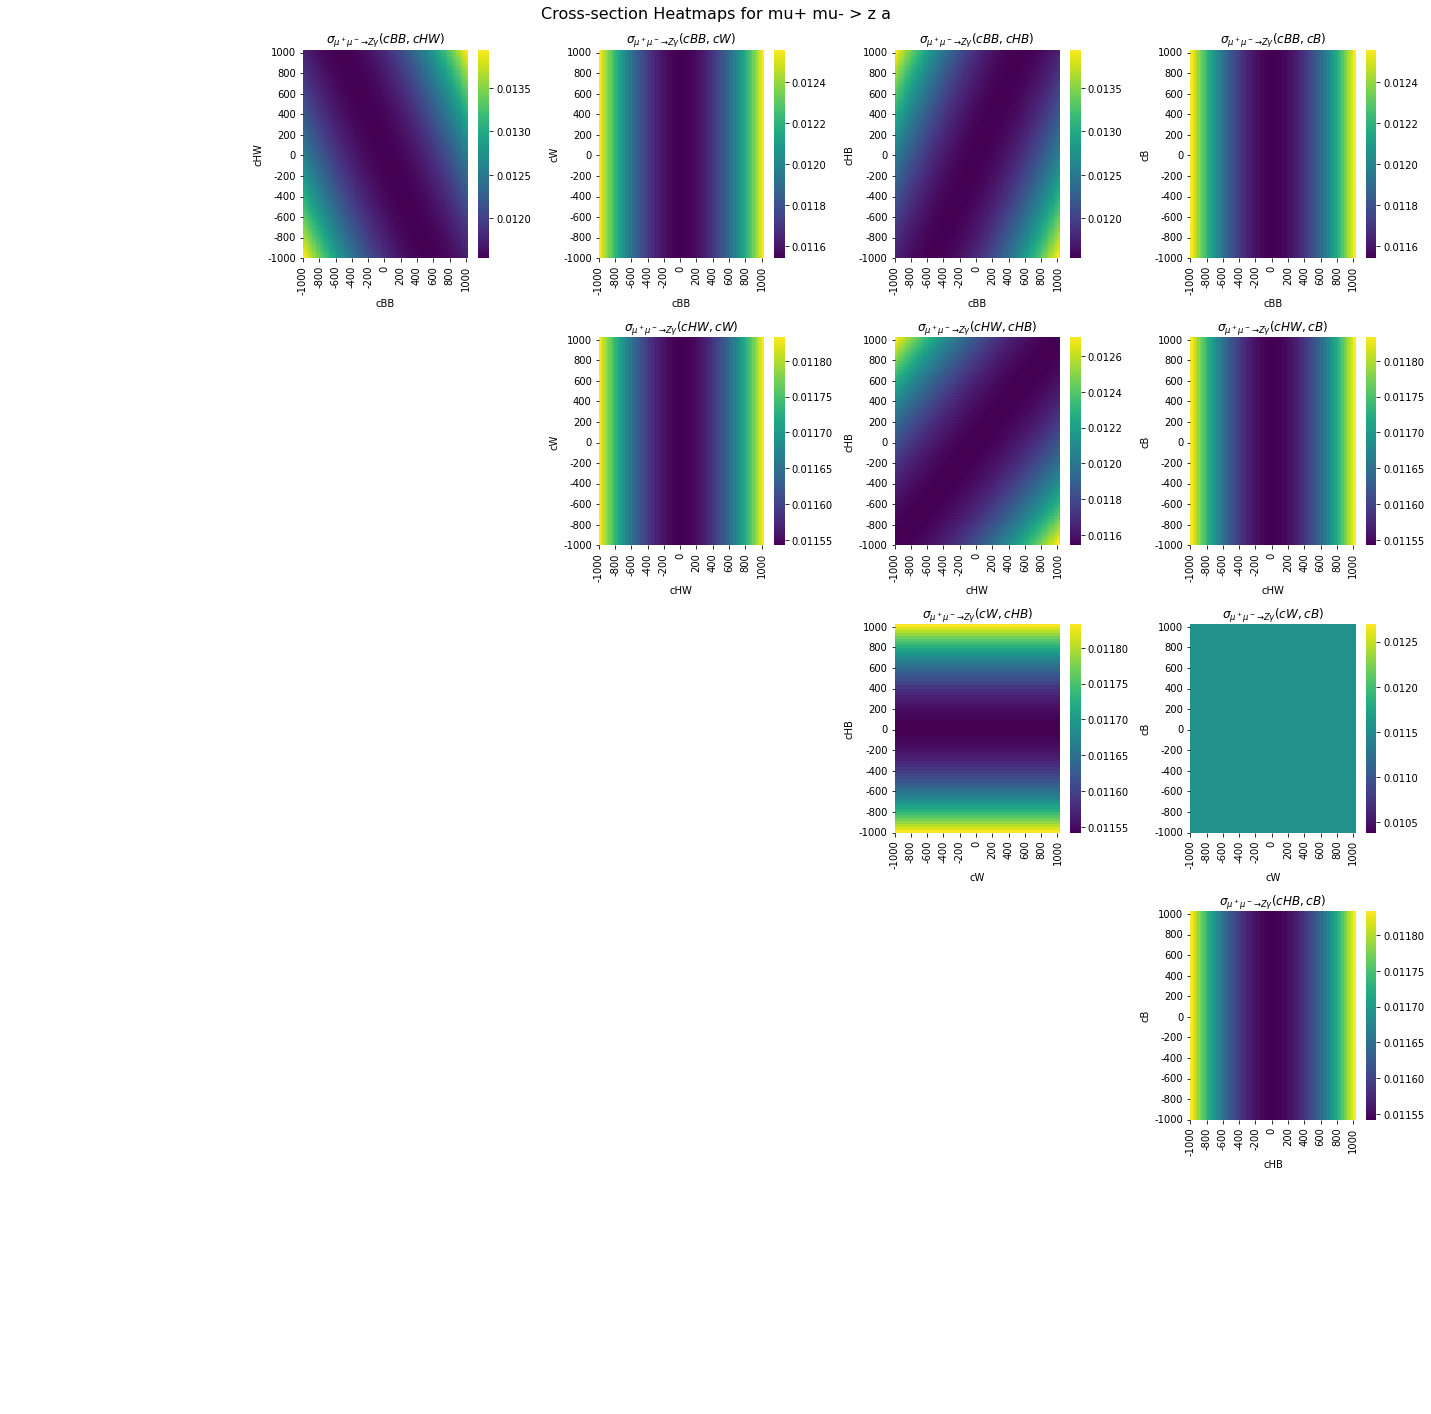

In [ ]:
# Generate 2D heatmaps

def plot_heatmaps_grid(process_name, com_energy):
    fig, axes = plt.subplots(len(params_list), len(params_list), figsize=(20, 20))
    

    
    for i in range(len(params_list)):
        for j in range(len(params_list)):
            if i >= j:
                axes[i, j].axis('off')
                continue
            
            p1, p2 = params_list[i], params_list[j]
            
            # Assign ranges 
            x_range = np.linspace(-1000, 1000, 70) 
            y_range = np.linspace(-1000, 1000, 70) 

            x_ticks = np.linspace(x_range[0], x_range[-1], 11)
            y_ticks = np.linspace(y_range[0], y_range[-1], 11)

            xtick_pos = np.linspace(0, len(x_range) - 1, 11)
            ytick_pos = np.linspace(0, len(y_range) - 1, 11)



            grid = np.zeros((len(x_range), len(y_range)))


            for x_idx, x in enumerate(x_range):
                for y_idx, y in enumerate(y_range):
                    coeffs = {p: 0 for p in params_list}
                    coeffs[p1] = x
                    coeffs[p2] = y
                    grid[y_idx, x_idx] = sigmaMupMumZa(coeffs, com_energy)

            
            sns.heatmap(grid, ax=axes[i, j], xticklabels=x_ticks, yticklabels=y_ticks, cmap="viridis", cbar=True)
            axes[i, j].set_xticks(xtick_pos)
            axes[i, j].set_xticklabels([f"{label:.0f}" for label in x_ticks])
            axes[i, j].set_yticks(ytick_pos)
            axes[i, j].set_yticklabels([f"{label:.0f}" for label in y_ticks])
            axes[i, j].invert_yaxis()  # Fix y-axis direction
            axes[i, j].set_xlabel(p1)
            axes[i, j].set_ylabel(p2)
            axes[i, j].set_title(f"$\\sigma_{{\\mu^+ \\mu^- \\to Z \\gamma}}({p1}, {p2})$", fontsize=12)
            
    plt.suptitle(f"Cross-section Heatmaps for {process_name} for COM energy {com_energy}\n", fontsize=16)
    plt.tight_layout()
    plt.show()

plot_heatmaps_grid("mu+ mu- > z a")
